# Implementing Vanilla VAE on FashionMNIST dataset

In [2]:
import os, sys

import numpy as np

from tqdm import tqdm
import torch
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset

from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

from models import vanilla_vae

In [3]:
device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


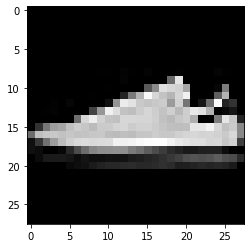

In [35]:
plt.imshow(dat[6].reshape((28,28)), cmap='gray', vmin=0, vmax=255)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


Text(0, 0.5, 'pixel intensity')

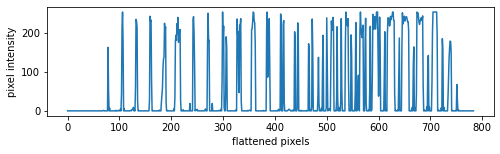

In [28]:
dat = dataset.data.detach().numpy().reshape((len(dataset.data), 28*28))
dat.shape

print(dataset.targets[:10])
# [0, 1, 3, 5, 6]
i = 9

plt.figure(figsize=(8,2))
plt.plot(dat[i])
plt.xlabel('flattened pixels')
plt.ylabel('pixel intensity')
# plt.plot(predx)

In [5]:
# Download and prepare dataset
train_ratio = 0.9
batch_size = 1000
dataset = FashionMNIST('~/datasets', download=True)

train_size = int(len(dataset.data)*train_ratio)
print('train_size =', train_size)
train_dataset = TensorDataset(dataset.data[:train_size], dataset.targets[:train_size])
val_dataset = TensorDataset(dataset.data[train_size:], dataset.targets[train_size:])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_size = 54000


In [4]:
# initialize VAE
img_size = 28
latent_size = 2

enc = vanilla_vae.Encoder(input_dim=img_size*img_size, hidden_dim=500, z_dim=latent_size).to(device)
dec = vanilla_vae.Decoder(z_dim=latent_size, hidden_dim=500, output_dim=img_size*img_size).to(device)
vae = vanilla_vae.VAE(enc, dec).to(device)

optim = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [5]:
# generate image from decoder
def gen_img(D=None, latent=None, image=None):
    if latent is not None:
        x = latent.to(device)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        image = D(x)
    y = image.cpu().detach().numpy()[0].reshape((img_size, img_size))
    return Image.fromarray((y * 255).astype('uint8'), mode='L').resize((img_size*8, img_size*8))

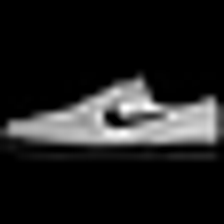

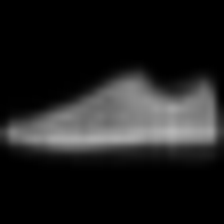

train loss = 256943.2812 val loss = 260312.2188: 100%|█████████████████████████████████████████| 500/500 [02:20<00:00,  3.56it/s]


In [6]:
# training loop
d1 = display.display(gen_img(D=dec, latent=torch.rand(latent_size)), display_id=True)
d2 = display.display(gen_img(D=dec, latent=torch.rand(latent_size)), display_id=True)
epochs = 500
pbar = tqdm(range(epochs), colour='green')
for epoch in pbar:
    for batch_x, _ in train_dataloader:
        # to device
        batch_x_dev = batch_x.to(device)
        # conversion
        batch_x_dev = batch_x_dev.float() / 255
        # reshape
        batch_x_dev = batch_x_dev.flatten(start_dim=1)
        # forward pass
        predicted, z_mu, z_var = vae(batch_x_dev)
        # reconstruction loss
        rec_loss = F.binary_cross_entropy(predicted, batch_x_dev, reduction='sum')
        # KL divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        train_loss = rec_loss + kl_loss
        # update parameters
        optim.zero_grad()
        train_loss.backward()
        optim.step()
    
    with torch.no_grad():
        for batch_x, _ in val_dataloader:
            # to device
            batch_x_dev = batch_x.to(device)
            # conversion
            batch_x_dev = batch_x_dev.float() / 255
            # reshape
            batch_x_dev = batch_x_dev.flatten(start_dim=1)
            # forward pass
            predicted, z_mu, z_var = vae(batch_x_dev)
            # reconstruction loss
            rec_loss = F.binary_cross_entropy(predicted, batch_x_dev, reduction='sum')
            # KL divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            # total loss
            val_loss = rec_loss + kl_loss
    
    pbar.set_description(f'train loss = {train_loss.item():.4f} val loss = {val_loss.item():.4f}')
    
    z_mu, z_var = enc(batch_x_dev[:1])
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)
    d1.update(gen_img(image=batch_x_dev[:1]))
    d2.update(gen_img(D=dec, latent=x_sample))
    

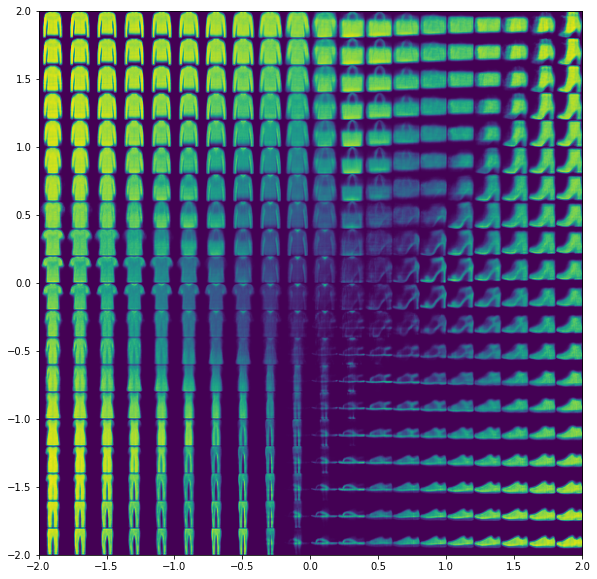

In [7]:
# draw the manifold! (only for latent_size = 2)
z_range = 2
z_itvl = 0.2
z1 = torch.arange(-z_range, z_range, z_itvl).to(device)
z2 = torch.arange(-z_range, z_range, z_itvl).to(device)
z_n = len(z1)

z_mesh = torch.meshgrid(z1, z2, indexing='ij')
z_vals = torch.stack((z_mesh[0].flatten(), z_mesh[1].flatten())).transpose(0,1)

manifolds = dec(z_vals).cpu().detach().numpy().reshape((z_n, z_n, img_size, img_size))

canvas = np.zeros((z_n*img_size, z_n*img_size))
for i in range(z_n):
    for j in range(z_n):
        canvas[i*img_size:(i+1)*img_size, j*img_size:(j+1)*img_size] = manifolds[i,j]

plt.figure(figsize=(10,10))
plt.imshow(canvas, extent=[-z_range, z_range, -z_range, z_range])